In [8]:
import sqlite3
import pandas as pd
import sklearn

In [9]:
con = sqlite3.connect('valorant.sqlite')

In [10]:
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

In [11]:
table_names = [table[0] for table in tables]
print(f"TABLES:\n {table_names}")

TABLES:
 ['Matches', 'Games', 'Game_Rounds', 'Game_Scoreboard']


In [12]:
dataframes = {}
for table in table_names:
    dataframes[table.lower()] = pd.read_sql_query(f"SELECT * FROM {table}", con)

for df_name, df in dataframes.items():
    print(f"{df_name}:\n {list(df.columns)}\n")

matches:
 ['MatchID', 'Date', 'Patch', 'EventID', 'EventName', 'EventStage', 'Team1ID', 'Team2ID', 'Team1', 'Team2', 'Team1_MapScore', 'Team2_MapScore']

games:
 ['GameID', 'MatchID', 'Map', 'Team1ID', 'Team2ID', 'Team1', 'Team2', 'Winner', 'Team1_TotalRounds', 'Team2_TotalRounds', 'Team1_SideFirstHalf', 'Team2_SideFirstHalf', 'Team1_RoundsFirstHalf', 'Team1_RoundsSecondtHalf', 'Team1_RoundsOT', 'Team2_RoundsFirstHalf', 'Team2_RoundsSecondtHalf', 'Team2_RoundsOT', 'Team1_PistolWon', 'Team1_Eco', 'Team1_EcoWon', 'Team1_SemiEco', 'Team1_SemiEcoWon', 'Team1_SemiBuy', 'Team1_SemiBuyWon', 'Team1_FullBuy', 'Team1_FullBuyWon', 'Team2_PistolWon', 'Team2_Eco', 'Team2_EcoWon', 'Team2_SemiEco', 'Team2_SemiEcoWon', 'Team2_SemiBuy', 'Team2_SemiBuyWon', 'Team2_FullBuy', 'Team2_FullBuyWon']

game_rounds:
 ['GameID', 'Team1ID', 'Team2ID', 'RoundHistory']

game_scoreboard:
 ['GameID', 'PlayerID', 'PlayerName', 'TeamAbbreviation', 'Agent', 'ACS', 'Kills', 'Deaths', 'Assists', 'PlusMinus', 'KAST_Percent'

### Which Team Comp is the best?

We first begin by doing the simplest analysis; of the team comps which has the highest win rate?

In [13]:
# get which team comp wins for every game
comp_dict = dict() # maps sorted agent comp to win count
game_ids = dataframes["game_scoreboard"]["GameID"].drop_duplicates()
print(len(game_ids.tolist()))

15878


In [14]:
from collections import defaultdict
from tqdm.notebook import tqdm


In [15]:
df_gs = dataframes["game_scoreboard"] 
comps = defaultdict(lambda : 0)
game_ids_idx = tqdm(game_ids)
for game_id in game_ids_idx:
    cur_game_df = df_gs.loc[df_gs["GameID"] == game_id]
    teams = list(cur_game_df["TeamAbbreviation"].drop_duplicates())
    #print(teams)
    teams = [x for x in teams if len(x) > 0]
    if len(teams) != 2: # we are missing data so we must skip the datapoint
        continue
    for t in teams:
        t_comp = cur_game_df.loc[cur_game_df["TeamAbbreviation"] == t]["Agent"]
        t_comp_list = t_comp.tolist()
        if len(t_comp_list) != 5 or '' in t_comp_list:
            continue
        team = sorted(t_comp.tolist())
        comps[tuple(team)] += 1

  0%|          | 0/15878 [00:00<?, ?it/s]

In [16]:
def print_sorted_dict(team_count):
    result = sorted(team_count.items(), key=lambda x : -x[1])
    for val in result:
        print(val)

In [17]:
sorted_dict = sorted(comps.items(), key=lambda x: -x[1])
#print_sorted_dict(comps)

In [18]:
# Get agent count
agent_count = defaultdict(lambda : 0)
for key in comps.keys():
    for agent in key:
        agent_count[agent] += 1

In [19]:
print(agent_count)

defaultdict(<function <lambda> at 0x7f3fdd712e60>, {'chamber': 35, 'jett': 497, 'skye': 315, 'sova': 490, 'viper': 387, 'astra': 301, 'raze': 431, 'sage': 378, 'kayo': 142, 'killjoy': 325, 'reyna': 291, 'cypher': 347, 'breach': 282, 'omen': 360, 'brimstone': 251, 'phoenix': 215, 'yoru': 73})


In [20]:
# Need to normalize by time agent has existed...
# get smallest gameID for every agent -> matchID -> datetime
from datetime import datetime, date
agent_add_date = defaultdict(lambda : datetime.max)
game_id_to_date = dict()
game_ids_idx = tqdm(sorted(game_ids) )
first_match_date = None
last_match_date = None
for game_id in game_ids_idx:
    df_gs = dataframes["game_scoreboard"] 
    cur_game_scoreboard_df = df_gs.loc[df_gs["GameID"] == game_id]
    agents = cur_game_scoreboard_df["Agent"].unique()
    
    df_games = dataframes["games"]
    cur_game_df = df_games.loc[df_games["GameID"] == game_id]
    match_id = cur_game_df["MatchID"].unique()[0]
    match_id_df = dataframes["matches"].loc[dataframes["matches"]["MatchID"] == match_id]
    date_data = match_id_df["Date"].unique()[0]
    datetime_data = datetime.strptime(date_data, "%Y-%m-%d %H:%M:%S")
    game_id_to_date[game_id] = datetime_data
    if first_match_date is None or datetime_data < first_match_date:
        first_match_date = datetime_data
    if last_match_date is None or datetime_data > last_match_date:
        last_match_date = datetime_data
    for agent in agents:
        # found first instance of agent
        
        if len(agent) > 1 and datetime_data <= agent_add_date[agent]:
            agent_add_date[agent] = datetime_data

    #if len(agents_found) >= len(agent_count.keys()):
    #    break

    

  0%|          | 0/15878 [00:00<?, ?it/s]

In [21]:
for agent, date in agent_add_date.items():
    print(f"Agent: {agent} \n Date: {date}\n")

Agent: reyna 
 Date: 2020-06-04 12:00:00

Agent: cypher 
 Date: 2020-05-21 12:00:00

Agent: omen 
 Date: 2020-05-24 12:00:00

Agent: raze 
 Date: 2020-05-21 12:00:00

Agent: sova 
 Date: 2020-05-21 12:00:00

Agent: phoenix 
 Date: 2020-05-21 12:00:00

Agent: jett 
 Date: 2020-05-21 12:00:00

Agent: killjoy 
 Date: 2020-08-12 18:30:00

Agent: breach 
 Date: 2020-05-21 12:00:00

Agent: sage 
 Date: 2020-05-21 12:00:00

Agent: viper 
 Date: 2020-06-04 14:00:00

Agent: brimstone 
 Date: 2020-05-21 12:00:00

Agent: skye 
 Date: 2020-11-06 07:00:00

Agent: yoru 
 Date: 2021-01-27 19:00:41

Agent: astra 
 Date: 2021-03-19 17:00:00

Agent: kayo 
 Date: 2021-07-08 04:30:00

Agent: chamber 
 Date: 2021-11-26 16:00:00



In [22]:
print("First match:", first_match_date)
print("Last match:", last_match_date)

First match: 2020-05-02 13:00:00
Last match: 2022-01-08 15:30:00


In [23]:
# Get time for each agent
agent_times = dict()
for agent, add_date in agent_add_date.items():
    agent_times[agent] = (last_match_date - add_date).days

In [24]:
print("Original Agent Times:", agent_times)

Original Agent Times: {'reyna': 583, 'cypher': 597, 'omen': 594, 'raze': 597, 'sova': 597, 'phoenix': 597, 'jett': 597, 'killjoy': 513, 'breach': 597, 'sage': 597, 'viper': 583, 'brimstone': 597, 'skye': 428, 'yoru': 345, 'astra': 294, 'kayo': 184, 'chamber': 42}


### Fix noise in data
 Essentially, we cluster agents based on when we first see them  
 if they sufficiently close (e.g. in the same cluster) then we can  
 tell they were actually available at the same time so we set         
 their "origin" time to the smallest value in the cluster  

In [25]:
import numpy as np
from sklearn.cluster import KMeans
milestones = np.array([int(x) for x in agent_times.values()])
clusters = 7
kmeans = KMeans(n_clusters=clusters).fit(milestones.reshape(-1,1))
print("Clusters:\n",kmeans.cluster_centers_)
print()
cluster_map = defaultdict(lambda : [])
for agent, time in agent_times.items():
    cluster_map[int(kmeans.predict(np.array(time).reshape(-1,1) ))].append(agent)
adjusted_agent_times = dict()
for key in cluster_map.keys():
    for agent in cluster_map[key]:
        adjusted_agent_times[agent] = max([agent_times[a] for a in cluster_map[key]])
print("Adjusted Agent Times:", adjusted_agent_times)
        
    

Clusters:
 [[594.18181818]
 [294.        ]
 [ 42.        ]
 [428.        ]
 [184.        ]
 [513.        ]
 [345.        ]]

Adjusted Agent Times: {'reyna': 597, 'cypher': 597, 'omen': 597, 'raze': 597, 'sova': 597, 'phoenix': 597, 'jett': 597, 'breach': 597, 'sage': 597, 'viper': 597, 'brimstone': 597, 'killjoy': 513, 'skye': 428, 'yoru': 345, 'astra': 294, 'kayo': 184, 'chamber': 42}


In [26]:
# Agent popularity by update
adjusted_clusters = sorted(list(set(adjusted_agent_times.values())))
print("Adjusted Clusters:", adjusted_clusters)

Adjusted Clusters: [42, 184, 294, 345, 428, 513, 597]


In [27]:
def date_to_milestone(date_days):
    milestone = adjusted_clusters[0]
    for i in range(len(adjusted_clusters)):
        if i == 0 and date_days <= adjusted_clusters[0]:
            return adjusted_clusters[0]
        if date_days > adjusted_clusters[i-1] and date_days <= adjusted_clusters[i]:
            return adjusted_clusters[i]
    raise Exception(f"Error: {date_days}")

In [29]:
# note: seems that older games don't have agents listed ...
# so we must check that there are agents
game_ids_idx = tqdm(game_ids)
agent_pick_by_milestone = dict()
team_pick_by_milestone = dict()
for cluster in adjusted_clusters:
    agent_pick_by_milestone[cluster] = defaultdict(lambda : 0)
    team_pick_by_milestone[cluster] = defaultdict(lambda : 0)
for game_id in game_ids_idx:
    df_gs =  dataframes["game_scoreboard"] 
    cur_game_df = df_gs.loc[df_gs["GameID"] == game_id]
    teams = list(cur_game_df["TeamAbbreviation"].drop_duplicates())
    #print(teams)
    teams = [x for x in teams if len(x) > 0]
    if len(teams) != 2: # we are missing data so we must skip the datapoint
        continue
    for t in teams:
        t_comp = cur_game_df.loc[cur_game_df["TeamAbbreviation"] == t]["Agent"]
        t_comp_list = t_comp.tolist()
        if len(t_comp_list) != 5 or '' in t_comp_list:
            continue
        date_days = (last_match_date - game_id_to_date[game_id]).days 
        try:
            milestone = date_to_milestone(date_days)
        except:
            print("Comp:", t_comp)
            print("Date_days:", date_days)
        for agent in t_comp_list:
            agent_pick_by_milestone[milestone][agent] += 1
        team = sorted(t_comp.tolist())
        team_pick_by_milestone[milestone][tuple(team)] += 1

  0%|          | 0/15878 [00:00<?, ?it/s]

In [30]:
game_ids_idx = tqdm(game_ids)

team_winrate_by_milestone = dict()
for cluster in adjusted_clusters:
    team_winrate_by_milestone[cluster] = defaultdict(lambda : 0)
for game_id in game_ids_idx:
    df_g = dataframes["games"]
    cur_g_data_df = df_g.loc[df_g["GameID"] == game_id]


  0%|          | 0/15878 [00:00<?, ?it/s]

In [31]:
#agent_pick_by_milestone
#print(team_pick_by_milestone)

In [32]:
agent_to_color = {
    'jett' : 'cornflowerblue',
    'chamber' : 'goldenrod',
    'sova' : 'lightsteelblue',
    'viper' : 'limegreen',
    'skye' : 'springgreen',
    'astra' : 'rebeccapurple',
    'raze' : 'darkorange',
    'sage' : 'aquamarine',
    'kayo' : 'dodgerblue',
    'killjoy' : 'yellow',
    'reyna' : 'orchid',
    'cypher' : 'whitesmoke',
    'breach' : 'coral',
    'omen' : 'darkslateblue',
    'brimstone' : 'chocolate', 
    'phoenix' : 'orangered',
    'yoru' : 'royalblue'
}
agent_to_num = {
    'jett' : 0,
    'chamber' : 1,
    'sova' : 2,
    'viper' : 3,
    'skye' : 4,
    'astra' : 5,
    'raze' : 6,
    'sage' :7,
    'kayo' : 8,
    'killjoy' : 9,
    'reyna' : 10,
    'cypher' : 11,
    'breach' : 12,
    'omen' : 13,
    'brimstone' : 14, 
    'phoenix' : 15,
    'yoru' : 16   
}

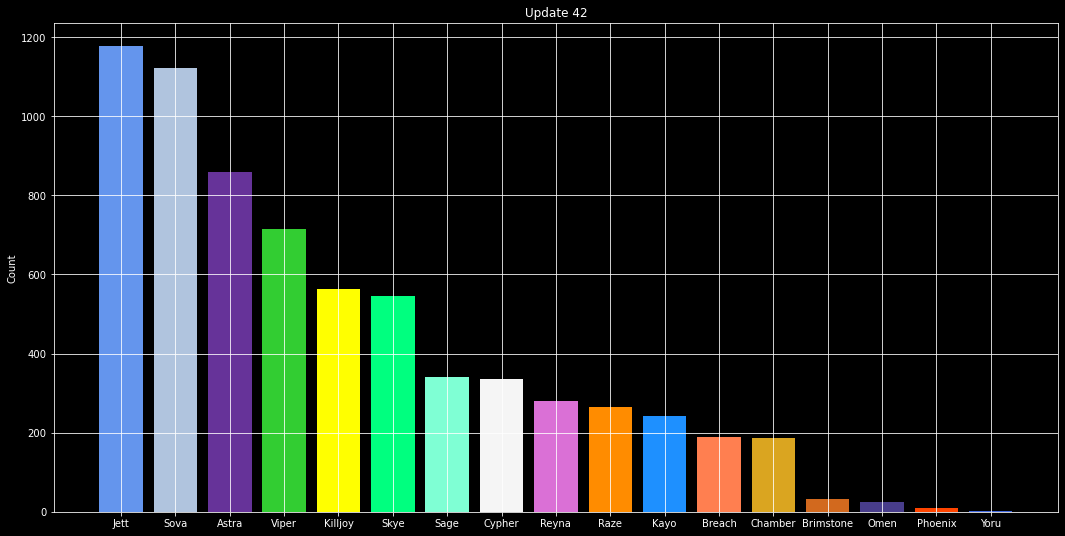

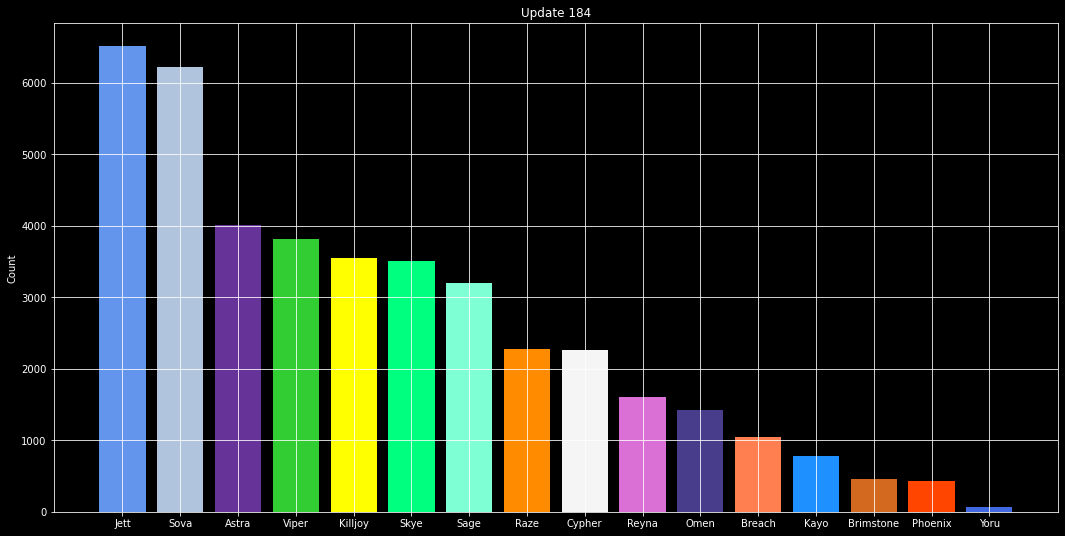

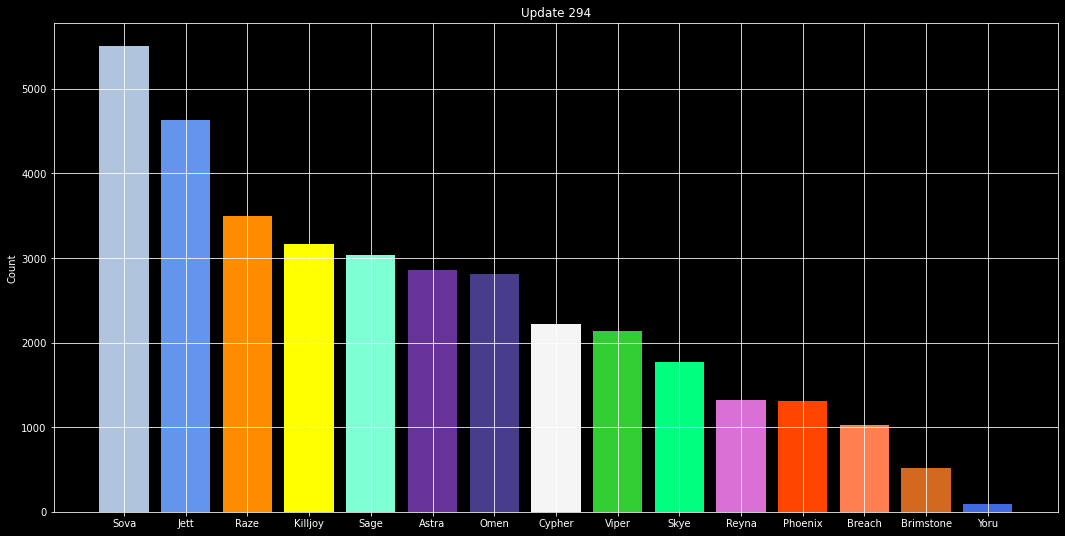

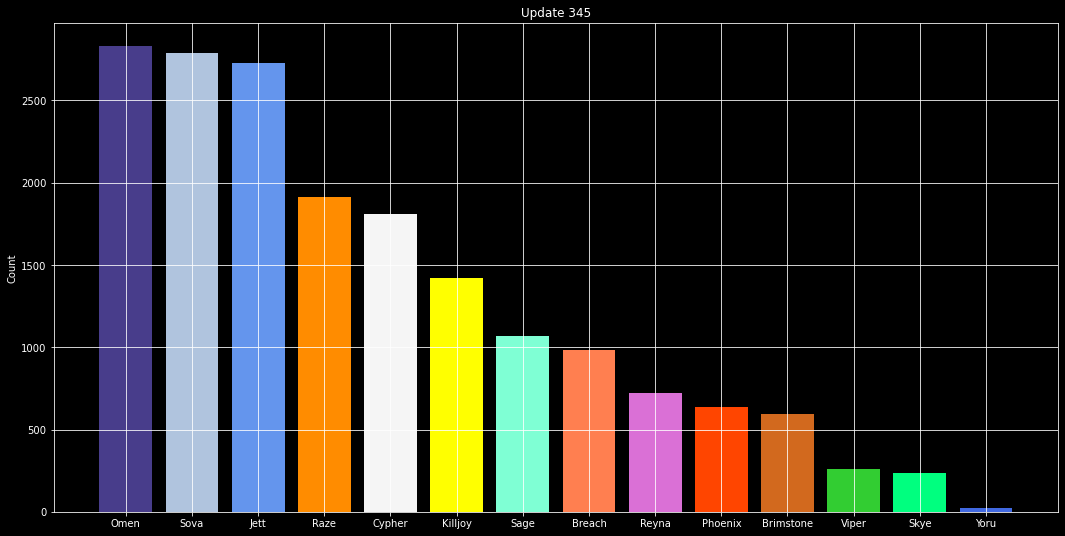

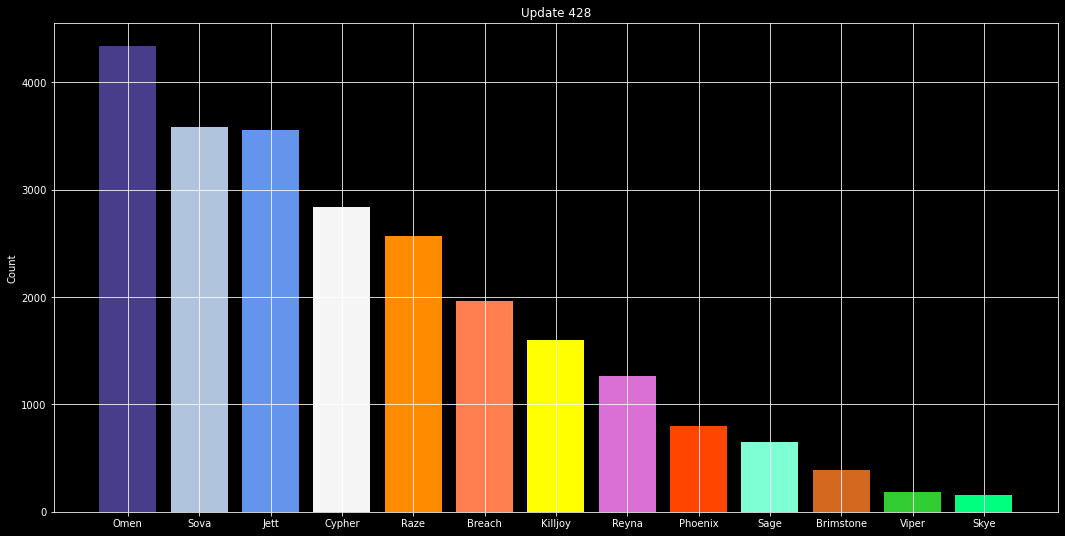

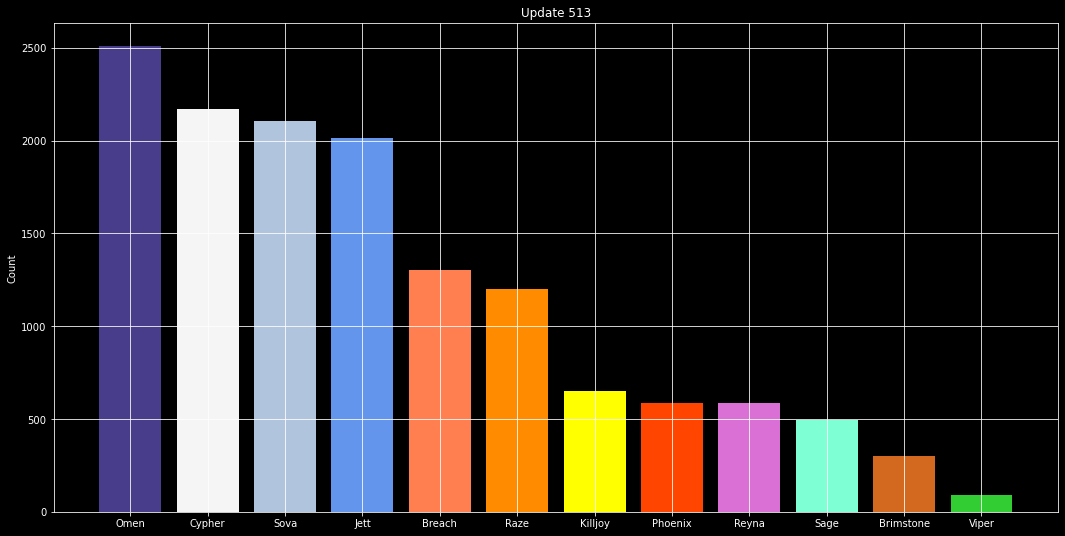

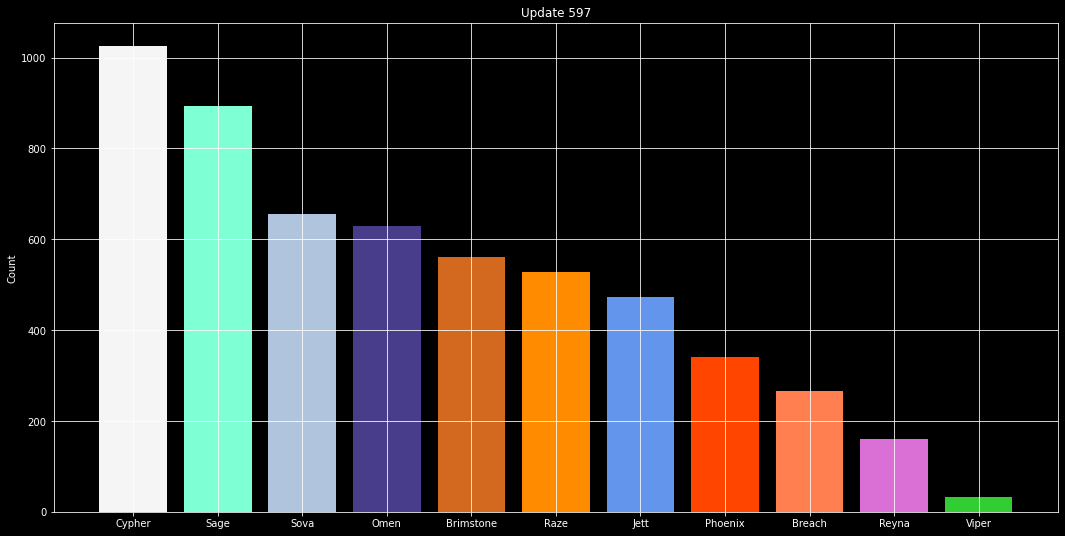

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
for milestone, picks in agent_pick_by_milestone.items():
    items = sorted(picks.items(), key=lambda x : -x[1])
    packed = list(zip(*items))
    agents, counts = packed[0], packed[1]
    colors = [agent_to_color[a] for a in agents]
    plt.figure(figsize=(18,9))
    #ax = plt.gca()
    plt.grid(None)
    #ax.set_facecolor('black')
    plt.title(f'Update {milestone}')
    plt.ylabel('Count')
    plt.bar([str(a[0]).upper() + a[1:] for a in agents], counts, color = colors)
    plt.show()

In [35]:
def keys_to_str(x):
    result = ""
    for agent in x:
        result += str(agent)[0].upper() + str(agent)[1:] + ", "
    return result[:-2]

<Figure size 432x288 with 0 Axes>

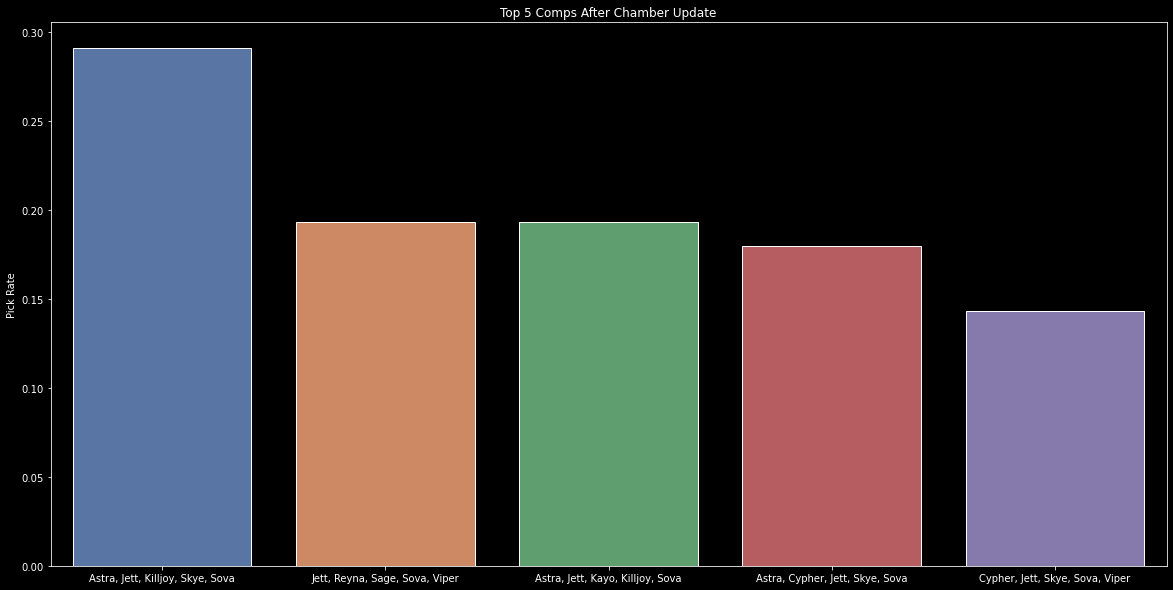

In [36]:
# Top three team comps for chamber update
plt.cla()
plt.clf()
#plt.style.use('dark_background')

n = 5 # number of comps to plot
ms = sorted(team_pick_by_milestone.keys())[0]
ordered_picks = sorted(team_pick_by_milestone[ms].items(), key=lambda x : -x[1])
top_three = ordered_picks[:n]
packed_teams = list(zip(*top_three))
comp, counts = packed_teams[0], packed_teams[1]
total_games = sum(counts)
comp_name = [keys_to_str(x) for x in comp]
plt.figure(figsize=(4*n,10))
plt.title(f"Top {n} Comps After Chamber Update")
plt.ylabel('Pick Rate')
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=np.array(comp_name), y=np.array(counts) / total_games)
plt.show()

In [37]:
def drop_dupes(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def get_other(num):
    if num == 1:
        return 2
    else:
        return 1

In [74]:
# Get winrate by team comp
# Convert Abbreviation to Team ID
game_ids_idx = tqdm(game_ids)
team_winrate_by_milestone = dict()
team_gamecount_by_milestone = dict()
team_wins_by_milestone = dict()
for cluster in adjusted_clusters:
    team_winrate_by_milestone[cluster] = defaultdict(lambda : 0)
    team_gamecount_by_milestone[cluster] = defaultdict(lambda : 0)
    team_wins_by_milestone[cluster] = defaultdict(lambda : 0)
for game_id in game_ids_idx:
    df_gs =  dataframes["game_scoreboard"] 
    cur_game_df = df_gs.loc[df_gs["GameID"] == game_id]
    teams = drop_dupes(list(cur_game_df["TeamAbbreviation"]))
    #print(teams)
    teams = [x for x in teams if len(x) > 0]
    if len(teams) != 2: # we are missing data so we must skip the datapoint
        continue
    df_g = dataframes["games"]
    cur_game_g_df = df_g.loc[df_g["GameID"] == game_id]
    team_count = 0
    for t in teams:
        team_count += 1
        
        t_comp = cur_game_df.loc[cur_game_df["TeamAbbreviation"] == t]["Agent"]
        t_comp_list = t_comp.tolist()
        if len(t_comp_list) != 5 or '' in t_comp_list:
            continue
        # Get team ID
        df_g = dataframes["games"]
        team_id = cur_game_g_df[f"Team{team_count}ID"]
        won = False
        won = True if cur_game_g_df["Team1_TotalRounds"].tolist()[0] > cur_game_g_df["Team2_TotalRounds"].tolist()[0] else False
        if team_count != 1:
            won = not won
        date_days = (last_match_date - game_id_to_date[game_id]).days 
        try:
            milestone = date_to_milestone(date_days)
        except:
            print("Comp:", t_comp)
            print("Date_days:", date_days)
        for agent in t_comp_list:
            agent_pick_by_milestone[milestone][agent] += 1
        team = sorted(t_comp.tolist())
        team_pick_by_milestone[milestone][tuple(team)] += 1
        team_gamecount_by_milestone[milestone][tuple(team)] += 1
        if won:
            team_winrate_by_milestone[milestone][tuple(team)] += 1
            team_wins_by_milestone[milestone][tuple(team)] += 1

  0%|          | 0/15878 [00:00<?, ?it/s]

In [39]:
for ms in team_winrate_by_milestone.keys():
    for team in team_winrate_by_milestone[ms].keys():
        team_winrate_by_milestone[ms][team] /= team_gamecount_by_milestone[ms][team]

In [40]:
# Compute 95% confidence intervals
import scipy.stats as st

team_winrate_ci_by_milestone = dict()
for cluster in adjusted_clusters:
    team_winrate_ci_by_milestone[cluster] = defaultdict(lambda : 0)
for ms in team_winrate_by_milestone.keys():
    for team in team_winrate_by_milestone[ms].keys():
        temp_data = np.zeros(team_gamecount_by_milestone[ms][team])
        wins = np.round(team_winrate_by_milestone[ms][team] * team_gamecount_by_milestone[ms][team]).astype(int)
        temp_data[:wins] = np.ones(wins)
        if team_gamecount_by_milestone[ms][team] > 30:
            team_winrate_ci_by_milestone[ms][team] = st.norm.interval(alpha=0.95, loc=team_winrate_by_milestone[ms][team], scale=st.sem(temp_data))
        else:
            team_winrate_ci_by_milestone[ms][team] = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=team_winrate_by_milestone[ms][team], scale=st.sem(temp_data))

/home/jared/miniconda3/envs/utility/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/jared/miniconda3/envs/utility/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/home/jared/miniconda3/envs/utility/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jared/miniconda3/envs/utility/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
ms = sorted(team_winrate_by_milestone.keys())[0]
#team_winrate_ci_by_milestone[ms]

(6, 2)
[0.10632375 0.08686376 0.1371234  0.12444215 0.11023869 0.10566686]


<Figure size 432x288 with 0 Axes>

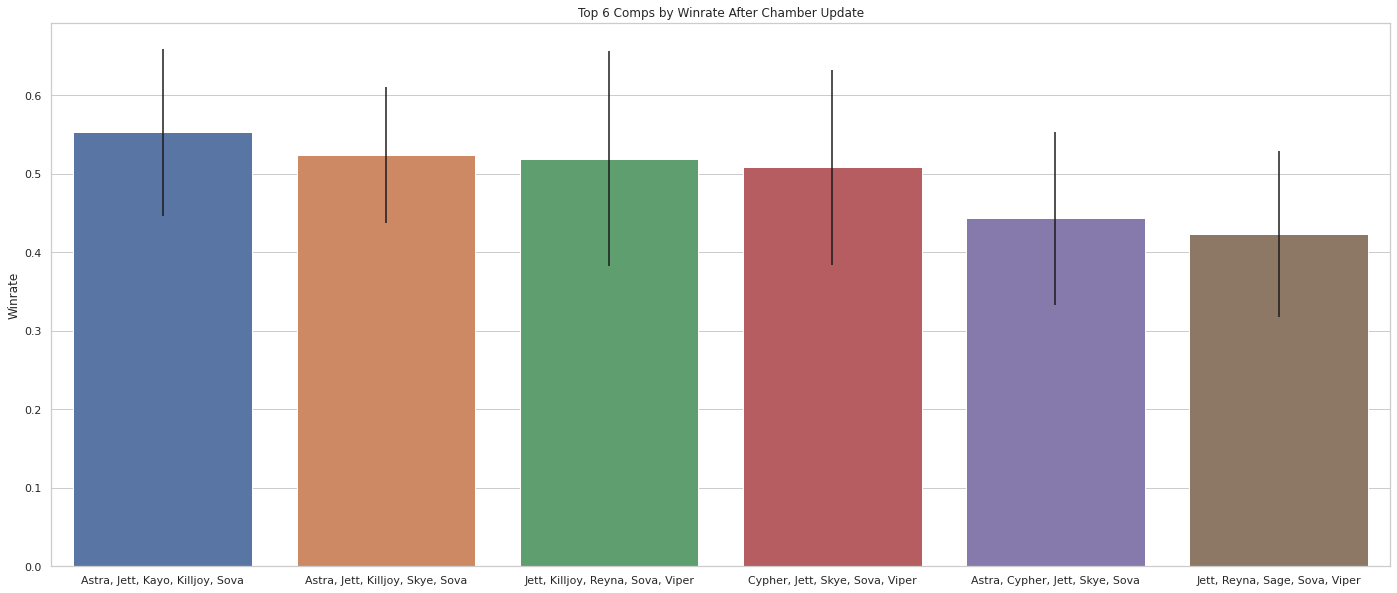

In [42]:
# Get comps with the highest win-rate
plt.cla()
plt.clf()
#plt.style.use('dark_background')

n = 6 # number of comps to plot
required_plays = 50 # number of required uses
ms = sorted(team_winrate_by_milestone.keys())[0]
ordered_picks = sorted(filter(lambda x : team_gamecount_by_milestone[ms][x[0]] > required_plays, team_winrate_by_milestone[ms].items()), key=lambda x : -x[1])

top_n = ordered_picks[:n]
packed_teams = list(zip(*top_n))
err_interval = list()
for i in range(len(packed_teams[0])):
    err_interval.append(list(team_winrate_ci_by_milestone[ms][packed_teams[0][i]]) )
comp, counts = packed_teams[0], packed_teams[1]
total_games = sum(counts)
comp_name = [keys_to_str(x) for x in comp]
plt.figure(figsize=(4*n,10))
plt.title(f"Top {n} Comps by Winrate After Chamber Update")
plt.ylabel('Winrate')
#print(err_interval)
sns.set_theme(style="whitegrid")
err_interval = np.array(err_interval,dtype=np.float32)
print(np.shape(err_interval))
ci_interval = (err_interval[:,1] - err_interval[:,0]) / 2
print(ci_interval)
ax = sns.barplot(x=np.array(comp_name), y=np.array(counts), capsize=0.1, yerr=ci_interval)
plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 3520x2200 with 0 Axes>

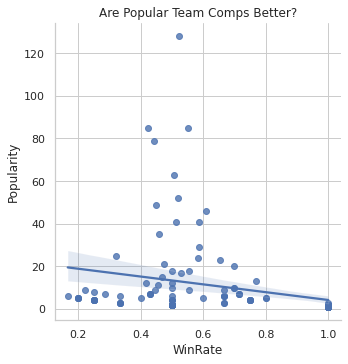

Correlation (Pearson-R): -0.25791594975765486
P-value: 0.003827495655340718


In [49]:
# Does team comp popularity correlate with win rate? 
# Get comps with the highest win-rate

import scipy.stats as st

plt.cla()
plt.clf()
ms = sorted(team_winrate_by_milestone.keys())[0] # choose a milestone
winrate_list = list()
popularity = list()
for team in team_winrate_by_milestone[ms]:
    winrate_list.append(team_winrate_by_milestone[ms][team])
    popularity.append(team_gamecount_by_milestone[ms][team])

winrate_arr = np.array(winrate_list)
popularity_arr = np.array(popularity)
scatter_df = pd.DataFrame({"WinRate":winrate_arr, "Popularity":popularity_arr})
r, p = st.pearsonr(popularity_arr, winrate_arr)
sns.lmplot(x="WinRate", y="Popularity", data=scatter_df)
plt.title("Are Popular Team Comps Better?")

plt.show()
print("Correlation (Pearson-R):", r)
print("P-value:", p)

In [119]:
# Correlation Monte Carlo Simulation
# -----------------------------------
# Simulates each winrate datapoint 
# with an estimator matching mean & 
# variance based on count
#
# For n > 30 central limit theorem
# should give good approx w/ normal
# distribution
#
# For n < 30 we can use binomial 
# distribution as these are a series
# of bernoulli RV's
# ----------------------------------
nan_bound = 20
binom_bound = 30
sim_count = 10000
ms = sorted(team_winrate_by_milestone.keys())[0]
spearman_r = np.zeros(sim_count)
spearman_p = np.zeros(sim_count)
pearson_r = np.zeros(sim_count)
pearson_p = np.zeros(sim_count)
sim_indices = tqdm(range(sim_count))
for j in sim_indices:
    winrate_sim = np.zeros(len(winrate_arr))
    i = 0
    for team in team_winrate_by_milestone[ms]:
        if popularity_arr[i] > binom_bound:
            #print("TEST")
            mean = winrate_arr[i]
            run = np.zeros(team_gamecount_by_milestone[ms][team])
            count = popularity_arr[i]
            run[:count] = np.ones(count)
            var = np.var(run)
            winrate_sim[i] = np.random.normal(loc=mean, scale=np.sqrt(var)/count)
        elif popularity_arr[i] > nan_bound:
            count = popularity_arr[i]
            mean = winrate_arr[i]
            winrate_sim[i] = np.random.binomial(n=count,p=mean) / count
        else:
            winrate_sim[i] = np.NAN
        i += 1
    winrate_sim_clean, pop_clean = zip(*filter(lambda x : not np.isnan(x[0]), zip(winrate_sim, popularity_arr)))
    scatter_df = pd.DataFrame({"WinRate":winrate_sim_clean, "Popularity":pop_clean})
    r, p = st.pearsonr(pop_clean, winrate_sim_clean)
    sr, sp = st.spearmanr(pop_clean, winrate_sim_clean)
    pearson_r[j] = r
    pearson_p[j] = p
    spearman_r[j] = sr
    spearman_p[j] = sp
    #sns.lmplot(x="WinRate", y="Popularity", data=scatter_df)
    #plt.title("Are Popular Team Comps Better?")

    #plt.show()
#print("(Pearson-R) Correlation:", r)
#print("(Pearson-R) P-value:", p)
#print("(Spearman-R) Correlation:", sr)
#print("(Spearman-R) P-value:", sp) 
#print(winrate_sim)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

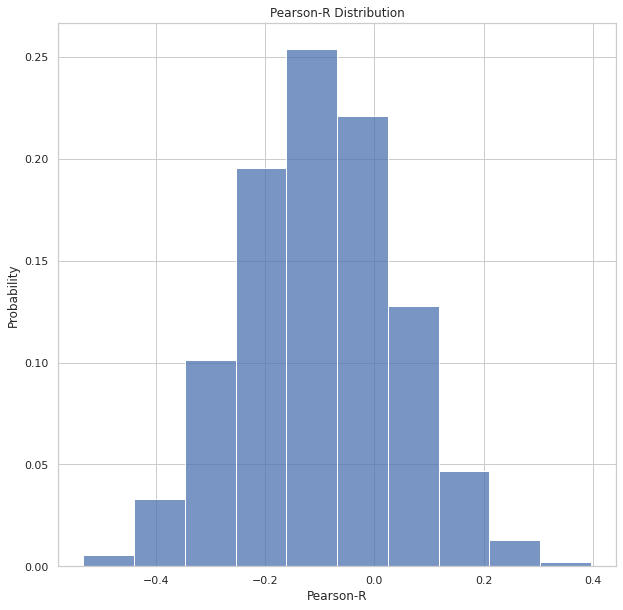

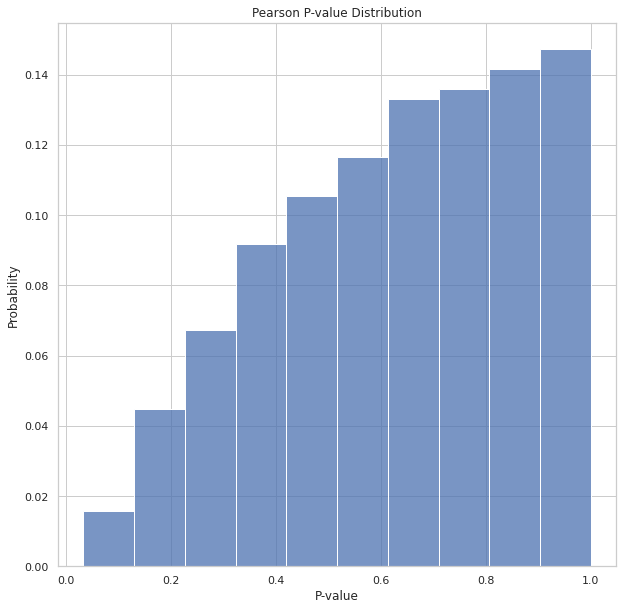

Mean Pearson-R: -0.09963179061556375
Mean P-value: 0.6309759801167238


In [126]:
plt.cla()
plt.clf()

# ------- Pearson-R --------

plt.figure(figsize=(10,10))
plt.title(f"Pearson-R Distribution")
plt.ylabel('Probability')
plt.xlabel('Pearson-R')
#print(err_interval)
sns.set_theme(style="whitegrid")

ax = sns.histplot(x=np.array(pearson_r), bins=10, stat='probability')
plt.show()

# ------- P-Value ----------

plt.figure(figsize=(10,10))
plt.title(f"Pearson P-value Distribution")
plt.ylabel('Probability')
plt.xlabel('P-value')
#print(err_interval)
sns.set_theme(style="whitegrid")

ax = sns.histplot(x=np.array(pearson_p), bins=10, stat='probability')
plt.show()

print(f"Mean Pearson-R: {np.mean(pearson_r)}")
print(f"Mean P-value: {np.mean(pearson_p)}")